In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

from src.ksd.kernel import IMQ, RBF, Linear
import src.high_dim.experiments as hd
import src.high_dim.analytical as hd_ana

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"

In [6]:
tf.random.set_seed(1)

DELTA = 2.

BANDWIDTH_POWER = 1.

STATISTIC = "mmd"

KERNEL = RBF

DIR = "../res"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"
EXTRA = ""

NREP = 5

In [7]:
def compute_analytical(stat_ana_class, dims, delta, bandwidth_power):
    res = {
        "dim": dims,
        "mean": [],
        "cond_var": [],
        "full_var": [],
        "m3_ub": [],
        "M3_ub": [],
    }

    for d in dims:
        if stat_ana_class == hd_ana.MMDLinearAnalytical:
            mu = np.eye(d)[:, 1] * delta

            sigma_mat = np.eye(d, dtype=np.float32) * 0.5
            sigma_mat[0, 0] = 0.5 * d
            
            stat_ana = stat_ana_class(
                dim=d,
                mu=mu,
                Sigma=sigma_mat,
            )
            
        else:
            stat_ana = stat_ana_class(
                dim=d,
                mu_norm=delta,
                bandwidth_power=bandwidth_power,
            )

        res["mean"].append(stat_ana.mean())
        res["cond_var"].append(stat_ana.cond_var())
        res["full_var"].append(stat_ana.full_var())
        res["m3_ub"].append(stat_ana.abs_cond_moment_ub(nu=3))
        res["M3_ub"].append(stat_ana.abs_full_moment_ub(nu=3))

    res_df = pd.DataFrame(res)
    return res_df
    

In [13]:
def run_repeat(dims, bandwidth_order, kernel_class, npop, statistic, nrep):
    res_analytical_list = []
    for i in range(nrep):
        res_analytical = hd.compute_population_moments(
            dims=dims, 
            bandwidth_order=bandwidth_order, 
            kernel_class=kernel_class,
            npop=npop,
            delta=DELTA,
            statistic=statistic,
        )

        res_analytical = res_analytical
        res_analytical = pd.DataFrame(res_analytical)
        res_analytical["dim"] = dims
        res_analytical.set_index("dim", drop=False, inplace=True)
        res_analytical_list.append(res_analytical)    
    return res_analytical_list
     

# Load results

In [14]:
# # load analytical res
# res_analytical_save = pd.read_csv(
#     f"{DIR}/res_analytical_{SUFFIX}.csv",
# )
# res_analytical = res_analytical_save.set_index("dim", drop=False)
# dims = res_analytical.dim.unique().tolist()

In [16]:
# dims = [1, 2, 4, 25, 50, 75, 100] #, 250, 500, 1000, 2000]
dims = [1, 2, 4, 25, 50, 75, 100, 250, 500, 1000, 2000]

In [17]:
# compute analytical res
NPOP = 6000 # 10000 # 4000

# res_analytical = hd.compute_population_quantities(
#     dims=dims, 
#     bandwidth_order=BANDWIDTH_POWER, 
#     kernel_class=KERNEL,
#     npop=NPOP,
#     delta=DELTA,
#     statistic=STATISTIC,
# )

# res_analytical_dict = res_analytical
# res_analytical = pd.DataFrame(res_analytical)
# res_analytical["dim"] = dims
# res_analytical.set_index("dim", drop=False, inplace=True)


res_analytical_list = run_repeat(
    dims=dims, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=KERNEL, 
    npop=NPOP, 
    statistic=STATISTIC,
    nrep=NREP,
)

  0%|                                                                                                                                                                                    | 0/11 [00:00<?, ?it/s]2023-02-13 17:20:52.224567: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-13 17:20:52.224626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2023-02-13 17:20:52.224633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2023-02-13 17:20:52.224755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2023-02-13 17:20:52.224777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2023-02-13 17:20:52.224781: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2

In [18]:
res_analytical_df = pd.concat(res_analytical_list, ignore_index=True)
res_analytical_df = res_analytical_df.groupby("dim").mean()

# Compute analytical forms/bounds

In [19]:
mmd_ana = compute_analytical(
    stat_ana_class=hd_ana.MMDAnalytical, 
    dims=dims, 
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

# Moments vs. dim

In [21]:
def plot(res_sim, res_expression):
    dims = res_expression["dim"].to_numpy()
    
    figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    axes[0].plot(dims, res_sim.loc[dims, "expectation"], marker="o", label="Truth")
    axes[0].plot(dims, res_expression["mean"], marker="x", label="Derived")
    axes[0].set_xlabel("Dim", fontsize=15)
    axes[0].set_ylabel("Mean", fontsize=15)
    axes[0].tick_params(labelsize=15)
    axes[0].legend(fontsize=11)
    axes[0].set_xscale("log")
    
    axes[1].plot(dims, res_sim.loc[dims, "cond_var"], marker="o", label="Truth")
    axes[1].plot(dims, res_expression["cond_var"], marker="x", label="Derived")
    axes[1].set_xlabel("Dim", fontsize=15)
    axes[1].set_ylabel(r"$\sigma_{\mathrm{cond}}^2$", fontsize=22)
    axes[1].tick_params(labelsize=15)
    axes[1].legend(fontsize=11)
    axes[1].set_xscale("log")

    axes[2].plot(dims, res_sim.loc[dims, "full_var"], marker="o", label="Truth")
    axes[2].plot(dims, res_expression["full_var"], marker="x", label="Derived")
    axes[2].set_xlabel("Dim", fontsize=15)
    axes[2].set_ylabel(r"$\sigma_{\mathrm{full}}^2$", fontsize=22)
    axes[2].tick_params(labelsize=15)
    axes[2].legend(fontsize=11)
    axes[2].set_xscale("log")

    plt.tight_layout()
    

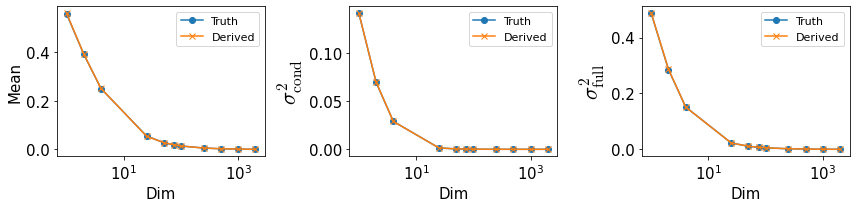

In [22]:
plot(res_analytical_df, mmd_ana)

# RBF-KSD

In [23]:
# # load analytical res
# res_analytical_save = pd.read_csv(
#     f"{DIR}/res_analytical_verify_ksd_RBF.csv",
# )
# res_analytical = res_analytical_save.set_index("dim", drop=False)
# dims = res_analytical.dim.unique().tolist()

## Analytical

In [24]:
dims_ksd = [1, 2, 4, 25, 50, 75, 100, 250, 500, 1000, 2000]
NPOP_ksd = 4000

In [25]:
# res_analytical_ksd = hd.compute_population_quantities(
#     dims=dims_ksd, 
#     bandwidth_order=BANDWIDTH_POWER, 
#     kernel_class=KERNEL,
#     npop=NPOP_ksd,
#     delta=DELTA,
#     statistic="ksd",
# )

# res_analytical_dict_ksd = res_analytical_ksd
# res_analytical_ksd = pd.DataFrame(res_analytical_ksd)
# res_analytical_ksd["dim"] = dims
# res_analytical_ksd.set_index("dim", drop=False, inplace=True)

In [26]:
res_analytical_list_ksd = run_repeat(
    dims=dims_ksd, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=RBF, 
    npop=NPOP_ksd, 
    statistic="ksd",
    nrep=NREP,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [08:43<00:00, 47.63s/it]


In [27]:
res_analytical_df_ksd = pd.concat(res_analytical_list_ksd, ignore_index=True)
res_analytical_df_ksd = res_analytical_df_ksd.groupby("dim").mean()

## Derived

In [28]:
ksd_ana = compute_analytical(
    stat_ana_class=hd_ana.KSDAnalytical, 
    dims=dims,
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

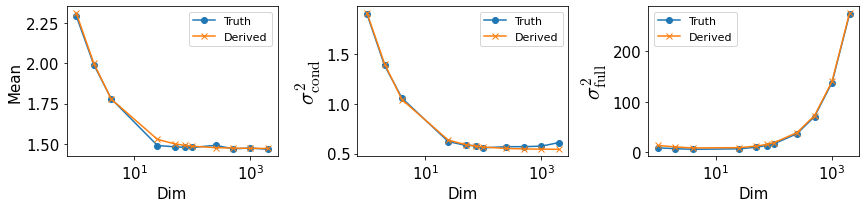

In [29]:
plot(res_analytical_df_ksd, ksd_ana)

# RBF-KSD and RBF-MMD

In [32]:
def plot_ksd_mmd(res_sim_ksd, res_ana_ksd, res_sim_mmd, res_ana_mmd):
    res_sim_list = [res_sim_ksd, res_sim_mmd]
    res_ana_list = [res_ana_ksd, res_ana_mmd]

    figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
    lw = 2.5
    ms = 8

    for i, (res_sim, res_ana) in enumerate(zip(res_sim_list, res_ana_list)):
        dims = res_ana["dim"].to_numpy()

        ax0 = axes[i][0]
        ax0.plot(dims, res_sim.loc[dims, "expectation"], marker="o", label="Truth", linewidth=lw, markersize=ms)
        ax0.plot(dims, res_ana["mean"], marker="x", label="Derived", linestyle="--", linewidth=lw, markersize=ms)
        ax0.set_xlabel("Dimension", fontsize=18)
        ax0.set_ylabel(r"Mean $D$", fontsize=18)
        ax0.tick_params(labelsize=15)
        ax0.legend(fontsize=15)
        ax0.set_xscale("log")
        
        ax1 = axes[i][1]
        ax1.plot(dims, res_sim.loc[dims, "cond_var"], marker="o", label="Truth", linewidth=lw, markersize=ms)
        ax1.plot(dims, res_ana["cond_var"], marker="x", label="Derived", linestyle="--", linewidth=lw, markersize=ms)
        ax1.set_xlabel("Dimension", fontsize=18)
        ax1.set_ylabel(r"$\sigma_{\mathrm{cond}}^2$", fontsize=25)
        ax1.tick_params(labelsize=15)
        ax1.legend([],[], frameon=False)
        ax1.set_xscale("log")

        ax2 = axes[i][2]
        ax2.plot(dims, res_sim.loc[dims, "full_var"], marker="o", label="Truth", linewidth=lw, markersize=ms)
        ax2.plot(dims, res_ana["full_var"], marker="x", label="Derived", linestyle="--", linewidth=lw, markersize=ms)
        ax2.set_xlabel("Dimension", fontsize=15)
        ax2.set_ylabel(r"$\sigma_{\mathrm{full}}^2$", fontsize=25)
        ax2.tick_params(labelsize=18)
        ax2.legend([],[], frameon=False)
        ax2.set_xscale("log")
        
        if i == 0:
            ax0.get_xaxis().set_visible(False)
            ax1.get_xaxis().set_visible(False)
            ax2.get_xaxis().set_visible(False)
        
        else:
            ax0.legend([],[], frameon=False)
        

    plt.subplots_adjust(
        wspace=0.38,
        hspace=0.1,
    )

#     plt.savefig(f"../figs/moments.pdf", bbox_inches="tight")

In [ ]:
plot_ksd_mmd(
    res_sim_ksd=res_analytical_df_ksd, 
    res_ana_ksd=ksd_ana, 
    res_sim_mmd=res_analytical_df, 
    res_ana_mmd=mmd_ana,
)

# Linear-MMD

## Analytical

In [ ]:
dims_lin = dims[1:]

In [110]:
NPOP_LIN = int(1e5)

res_analytical_lin = hd.compute_population_quantities(
    dims=dims_lin, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=Linear,
    npop=NPOP_LIN,
    delta=DELTA,
    statistic="mmd",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [36:48<00:00, 220.86s/it]


In [111]:
res_analytical_dict_lin = res_analytical_lin
res_analytical_lin = pd.DataFrame(res_analytical_lin)
res_analytical_lin["dim"] = dims_lin
res_analytical_lin.set_index("dim", drop=False, inplace=True)

In [122]:
res_analytical_lin_backup = res_analytical_lin.copy()

In [123]:
# repeat   
res_analytical_lin_list = []
for i in range(20):
    res_analytical_lin = hd.compute_population_quantities(
        dims=dims_lin, 
        bandwidth_order=BANDWIDTH_POWER, 
        kernel_class=Linear,
        npop=10000,
        delta=DELTA,
        statistic="mmd",
    )
    
    res_analytical_dict_lin = res_analytical_lin
    res_analytical_lin = pd.DataFrame(res_analytical_lin)
    res_analytical_lin["dim"] = dims_lin
    res_analytical_lin.set_index("dim", drop=False, inplace=True)
    res_analytical_lin_list.append(res_analytical_lin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.60s/it]


In [125]:
res_analytical_lin_df = pd.concat(res_analytical_lin_list, ignore_index=True)

## Derived

In [127]:
lin_ana = compute_analytical(
    stat_ana_class=hd_ana.MMDLinearAnalytical, 
    dims=dims_lin,
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

In [146]:
def plot_rep(res_sim, res_expression):
    dims = res_expression["dim"].to_numpy()
    
    figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    sns.lineplot(ax=axes[0], data=res_sim, x="dim", y="expectation", label="Simulated")
    axes[0].plot(dims, res_expression["mean"], marker="x", label="Derived")
    axes[0].set_xlabel("Dim", fontsize=15)
    axes[0].set_ylabel("Mean", fontsize=15)
    axes[0].tick_params(labelsize=15)
    axes[0].legend(fontsize=11)
    axes[0].set_xscale("log")
    
    sns.lineplot(ax=axes[1], data=res_sim, x="dim", y="cond_var", label="Simulated")
#     axes[1].plot(dims, res_sim.loc[dims, "cond_var"], marker="o", label="Truth")
    axes[1].plot(dims, res_expression["cond_var"], marker="x", label="Derived")
    axes[1].set_xlabel("Dim", fontsize=15)
    axes[1].set_ylabel(r"$\sigma_{\mathrm{cond}}^2$", fontsize=22)
    axes[1].tick_params(labelsize=15)
    axes[1].legend(fontsize=11)
    axes[1].set_xscale("log")

    sns.lineplot(ax=axes[2], data=res_sim, x="dim", y="full_var", label="Simulated")
#     axes[2].plot(dims, res_sim.loc[dims, "full_var"], marker="o", label="Truth")
    axes[2].plot(dims, res_expression["full_var"], marker="x", label="Derived")
    axes[2].set_xlabel("Dim", fontsize=15)
    axes[2].set_ylabel(r"$\sigma_{\mathrm{full}}^2$", fontsize=22)
    axes[2].tick_params(labelsize=15)
    axes[2].legend(fontsize=11)
    axes[2].set_xscale("log")


In [ ]:
plot_rep(res_analytical_lin_df, lin_ana)